<a href="https://colab.research.google.com/github/KORALLLL/MTUCI_EMNIST/blob/Artem/lenet/Artem_week8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train dataset: MNIST + EMNIST letters

Test dataset: dataset of DreamTeam

Training sample size: 36960

Testing sample size: 16784

Loss function: Cross Entropy Loss

Optimizer: Adam
_______________
lr = 0.005

betas = (0.8, 0.9)

eps = 1e-8

weight_decay = 0.001

amsgrad = False
_________________
Batch size: 1120

***IMPORT***

---

In [ ]:
import torch
import torchvision.datasets
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm_notebook as bar
import plotly.graph_objects as go


In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [ ]:
import scipy.stats as stats

***REPO***

---



In [ ]:
!git clone https://github.com/KORALLLL/MTUCI_EMNIST.git

Cloning into 'MTUCI_EMNIST'...
remote: Enumerating objects: 36629, done.
remote: Counting objects: 100% (12989/12989), done.
remote: Compressing objects: 100% (12816/12816), done.
remote: Total 36629 (delta 275), reused 12808 (delta 160), pack-reused 23640
Receiving objects: 100% (36629/36629), 134.88 MiB | 13.09 MiB/s, done.
Resolving deltas: 100% (560/560), done.


***TORCH.DEVICE***

---



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

***DATASET***

---



In [ ]:
emnist_train = torchvision.datasets.EMNIST('./', split='letters', download = True, train = True)
mnist_train = torchvision.datasets.EMNIST('./', split='mnist', download = True, train = True)
emnist_val = torchvision.datasets.EMNIST('./', split='letters', download = True, train = False)
mnist_val = torchvision.datasets.EMNIST('./', split='mnist', download = True, train = False)

emnist_train_data = emnist_train.data
mnist_train_data = mnist_train.data
train_data = torch.cat([emnist_train_data[:24960], mnist_train_data[:12000]], dim=0).float().unsqueeze(1).to(device) / 255

emnist_val_data = emnist_val.data
mnist_val_data = mnist_val.data
val_data = torch.cat([emnist_val_data, mnist_val_data], dim=0).float().unsqueeze(1).to(device) / 255

temp_emnist_train_labels = emnist_train.targets[:24960]
emnist_train_labels = []

temp_emnist_val_labels = emnist_val.targets
emnist_val_labels = []

for i in range(len(temp_emnist_train_labels)):
  if temp_emnist_train_labels[i]==15:
    emnist_train_labels.append(torch.tensor(0))
  elif temp_emnist_train_labels[i]>15:
    emnist_train_labels.append(temp_emnist_train_labels[i]+8)
  else:
    emnist_train_labels.append(temp_emnist_train_labels[i]+9)

for i in range(len(temp_emnist_val_labels)):
  if temp_emnist_val_labels[i]==15:
    emnist_val_labels.append(torch.tensor(0))
  elif temp_emnist_val_labels[i]>15:
    emnist_val_labels.append(temp_emnist_val_labels[i] + 8)
  else:
    emnist_val_labels.append(temp_emnist_val_labels[i]+9)

mnist_train_labels = mnist_train.targets
train_labels = torch.cat([torch.stack(emnist_train_labels[:24960]), mnist_train_labels[:12000]], dim=0).to(device)

mnist_val_labels = mnist_val.targets
val_labels = torch.cat([torch.stack(emnist_val_labels), mnist_val_labels], dim=0).to(device)


file = open('MTUCI_EMNIST/dataset.pkl', 'rb')
test_dataset = pickle.load(file)
file.close()

test_data = test_dataset['data'].numpy()
test_data = np.flip(test_data, axis = 3)
test_data = np.rot90(test_data, k=1, axes=(2,3))
test_data = 1 - test_data
test_data = torch.from_numpy(test_data).float().to(device)
test_labels = test_dataset['targets'].to(device)

100%|██████████| 561753746/561753746 [00:30<00:00, 18684130.56it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
class Block(torch.nn.Module):
  def __init__(self, in_channels, out_channels, padding):
    super(Block, self).__init__()
    self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=padding)
    self.bn = torch.nn.BatchNorm2d(out_channels)
    self.act = torch.nn.ReLU6()
    self.dp = torch.nn.Dropout(p=0.05)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.act(x)
    x = self.dp(x)
    return x

In [ ]:
class Block1(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Block1, self).__init__()
    self.block1 = Block(in_channels, out_channels, 1)
    self.block2 = Block(out_channels, out_channels, 1)
    self.block3 = Block(out_channels, out_channels, 1)
  def forward(self,x):
    x = self.block1(x)
    temp = x
    x = self.block2(x)
    x = self.block3(x)
    x = torch.add(x, temp)
    return x

In [ ]:
class Block2(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Block2, self).__init__()
    self.block1 = Block(in_channels, out_channels, 0)
    self.block2 = Block(out_channels, out_channels, 1)
    self.block3 = Block(out_channels, out_channels, 1)
  def forward(self, x):
    x = self.block1(x)
    temp = x
    x = self.block2(x)
    x = self.block3(x)
    x = torch.add(x, temp)
    return x

In [ ]:
class Net1(torch.nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    self.block1 = Block1(1,4)
    self.block2 = Block1(4,8)
    self.pool1 = torch.nn.Sequential(
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.ReLU6()
    )
    self.block3 = Block2(8, 16)
    self.block4 = Block2(16,32)
    self.pool2 = torch.nn.Sequential(
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.ReLU6()
    )
    self.fc1 = torch.nn.Linear(32*5*5,120)
    self.act1 = torch.nn.ReLU6()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act2 = torch.nn.ReLU6()
    self.fc3 = torch.nn.Linear(84,35)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.pool1(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.pool2(x)
    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

In [ ]:
class Net2(torch.nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.block1 = Block1(1,4)
    self.block2 = Block1(4,8)
    self.block3 = Block1(8,16)
    self.pool1 = torch.nn.Sequential(
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.ReLU6()
    )
    self.block4 = Block1(16,32)
    self.block5 = Block2(32, 64)
    self.block6 = Block2(64,128)
    self.pool2 = torch.nn.Sequential(
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.ReLU6()
    )
    self.fc1 = torch.nn.Linear(128*5*5,120)
    self.act1 = torch.nn.ReLU6()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act2 = torch.nn.ReLU6()
    self.fc3 = torch.nn.Linear(84,35)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.pool1(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.pool2(x)
    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

In [ ]:
class Net3(torch.nn.Module):
  def __init__(self):
    super(Net3, self).__init__()
    self.block1 = Block1(1,4)
    self.block2 = Block1(4,8)
    self.block3 = Block1(8,16)
    self.block4 = Block1(16,32)
    self.pool1 = torch.nn.Sequential(
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.ReLU6()
    )
    self.block5 = Block1(32,64)
    self.block6 = Block2(64, 128)
    self.block7 = Block1(128, 256)
    self.block8 = Block2(256,512)
    self.pool2 = torch.nn.Sequential(
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.ReLU6()
    )
    self.fc1 = torch.nn.Linear(512*5*5,120)
    self.act1 = torch.nn.ReLU6()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act2 = torch.nn.ReLU6()
    self.fc3 = torch.nn.Linear(84,35)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.pool1(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.block7(x)
    x = self.block8(x)
    x = self.pool2(x)
    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

***NET***

In [ ]:
batch_size = 560
test_accuracies = []
for i in range(1):
  lenet = Net1().to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lenet.parameters(), lr = 0.005, betas = (0.8, 0.9), eps = 1e-8, weight_decay = 0.001, amsgrad = False)
  test_accuracy = []
  for epoch in bar(range(100), desc = 'LEARNING', leave=False):
    indexs = np.random.permutation(len(train_data))

    for start_index in range(0, len(train_data), batch_size):
      optimizer.zero_grad()
      batch_index = indexs[start_index: start_index + batch_size]
      labels_batch = train_labels[batch_index].to(device)

      images_batch = train_data[batch_index].to(device)
      prediction = lenet.forward(images_batch)
      loss_value = loss(prediction, labels_batch)
      loss_value.backward()
      optimizer.step()

    lenet.eval()
    with torch.no_grad():
      prediction_test = lenet.forward(test_data)
      test_acc = (prediction_test.argmax(dim = 1) == test_labels).float().mean().data.cpu()
      test_accuracy.append(test_acc)
    lenet.train()

  test_accuracies.append(test_accuracy)

In [ ]:
batch_size = 560
test_accuracies = []
for i in range(1):
  lenet2 = Net2().to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lenet2.parameters(), lr = 0.005, betas = (0.8, 0.9), eps = 1e-8, weight_decay = 0.001, amsgrad = False)
  test_accuracy = []
  for epoch in bar(range(100), desc = 'LEARNING', leave=False):
    indexs = np.random.permutation(len(train_data))

    for start_index in range(0, len(train_data), batch_size):
      optimizer.zero_grad()
      batch_index = indexs[start_index: start_index + batch_size]
      labels_batch = train_labels[batch_index].to(device)

      images_batch = train_data[batch_index].to(device)
      prediction = lenet2.forward(images_batch)
      loss_value = loss(prediction, labels_batch)
      loss_value.backward()
      optimizer.step()

    lenet2.eval()
    with torch.no_grad():
      prediction_test = lenet2.forward(test_data)
      test_acc = (prediction_test.argmax(dim = 1) == test_labels).float().mean().data.cpu()
      test_accuracy.append(test_acc)
    lenet2.train()

  test_accuracies.append(test_accuracy)

In [ ]:
batch_size = 560
test_accuracies = []
for i in range(1):
  lenet3 = Net3().to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lenet3.parameters(), lr = 0.005, betas = (0.8, 0.9), eps = 1e-8, weight_decay = 0.001, amsgrad = False)
  test_accuracy = []
  for epoch in bar(range(100), desc = 'LEARNING', leave=False):
    indexs = np.random.permutation(len(train_data))

    for start_index in range(0, len(train_data), batch_size):
      optimizer.zero_grad()
      batch_index = indexs[start_index: start_index + batch_size]
      labels_batch = train_labels[batch_index].to(device)

      images_batch = train_data[batch_index].to(device)
      prediction = lenet3.forward(images_batch)
      loss_value = loss(prediction, labels_batch)
      loss_value.backward()
      optimizer.step()

    lenet3.eval()
    with torch.no_grad():
      prediction_test = lenet.forward(test_data)
      test_acc = (prediction_test.argmax(dim = 1) == test_labels).float().mean().data.cpu()
      test_accuracy.append(test_acc)
    lenet3.train()

  test_accuracies.append(test_accuracy)

***EXPERIMENT***

In [ ]:
for i in range(1):
  accuracy_net = []
  for experiment in bar(range(10), desc = 'EXPERIMENT', leave = False):

    loss = torch.nn.CrossEntropyLoss()
    lenet = Net1().to(device)

    optimizer = torch.optim.Adam(lenet.parameters(), lr = 0.005, betas = (0.8, 0.9), eps = 1e-8, weight_decay = 0.001, amsgrad = False)
    batch_size = 1120
    max_acc = 0

    for epoch in bar(range(100), leave=False):
      order = np.random.permutation(len(train_data))

      for start_index in range(0, len(train_data), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        data_batch = train_data[batch_indexes]
        labels_batch= train_labels[batch_indexes]

        preds = lenet.forward(data_batch)

        loss_val = loss(preds, labels_batch)
        loss_val.backward()

        optimizer.step()
      lenet.eval()
      with torch.no_grad():
        test_preds = lenet.forward(test_data)
        accuracy = (test_preds.argmax(dim=1)==test_labels).float().mean().data.cpu()
        max_acc = max(max_acc, accuracy)
      lenet.train()
    accuracy_net.append(max_acc)
    print(max_acc)
  print(*accuracy_net)

In [ ]:
acc_1 = "tensor(0.8296) tensor(0.8268) tensor(0.8268) tensor(0.8240) tensor(0.8371) tensor(0.8271) tensor(0.8326) tensor(0.8284) tensor(0.8226) tensor(0.8293) tensor(0.8302) tensor(0.8412) tensor(0.8322)"

In [ ]:
for i in range(1):
  accuracy_net = []
  for experiment in bar(range(10), desc = 'EXPERIMENT', leave = False):

    loss = torch.nn.CrossEntropyLoss()
    lenet2 = Net2().to(device)

    optimizer = torch.optim.Adam(lenet2.parameters(), lr = 0.005, betas = (0.8, 0.9), eps = 1e-8, weight_decay = 0.001, amsgrad = False)
    batch_size = 1120
    max_acc = 0

    for epoch in bar(range(100), leave=False):
      order = np.random.permutation(len(train_data))

      for start_index in range(0, len(train_data), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        data_batch = train_data[batch_indexes]
        labels_batch= train_labels[batch_indexes]

        preds = lenet.forward(data_batch)

        loss_val = loss(preds, labels_batch)
        loss_val.backward()

        optimizer.step()
      lenet2.eval()
      with torch.no_grad():
        test_preds = lenet.forward(test_data)
        accuracy = (test_preds.argmax(dim=1)==test_labels).float().mean().data.cpu()
        max_acc = max(max_acc, accuracy)
      lenet2.train()
    accuracy_net.append(max_acc)
    print(max_acc)
  print(*accuracy_net)

In [ ]:
acc_2 = "tensor(0.8413) tensor(0.8465) tensor(0.8401) tensor(0.8527) tensor(0.8322) tensor(0.8512) tensor(0.8364) tensor(0.8344) tensor(0.8313) tensor(0.8476) tensor(0.8425) tensor(0.8371) tensor(0.8405) tensor(0.8407) tensor(0.8521) tensor(0.8492) tensor(0.8497) tensor(0.8502)"

In [ ]:
for i in range(1):
  accuracy_net = []
  for experiment in bar(range(10), desc = 'EXPERIMENT', leave = False):

    loss = torch.nn.CrossEntropyLoss()
    lenet3 = Net3().to(device)

    optimizer = torch.optim.Adam(lenet3.parameters(), lr = 0.005, betas = (0.8, 0.9), eps = 1e-8, weight_decay = 0.001, amsgrad = False)
    batch_size = 1120
    max_acc = 0

    for epoch in bar(range(100), leave=False):
      order = np.random.permutation(len(train_data))

      for start_index in range(0, len(train_data), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        data_batch = train_data[batch_indexes]
        labels_batch= train_labels[batch_indexes]

        preds = lenet3.forward(data_batch)

        loss_val = loss(preds, labels_batch)
        loss_val.backward()

        optimizer.step()
      lenet.eval()
      with torch.no_grad():
        test_preds = lenet3.forward(test_data)
        accuracy = (test_preds.argmax(dim=1)==test_labels).float().mean().data.cpu()
        max_acc = max(max_acc, accuracy)
      lenet3.train()
    accuracy_net.append(max_acc)
    print(max_acc)
  print(*accuracy_net)

In [ ]:
acc_3 = "tensor(0.8422) tensor(0.8501) tensor(0.8466) tensor(0.8312) tensor(0.8431) tensor(0.8348) tensor(0.8348) tensor(0.8376) tensor(0.8372) tensor(0.8341) tensor(0.8505) tensor(0.8429) "

In [ ]:
samples = [acc_1, acc_2, acc_3]
for i in range(len(samples)):
    samples[i] = list(map(float, samples[i].replace("tensor(", '').replace(')', '').replace("[","").replace("]", "").split()))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9bafb98d90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9bafb992d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9bafb98af0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9bafb99810>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9bafb99ab0>,
 'means': []}

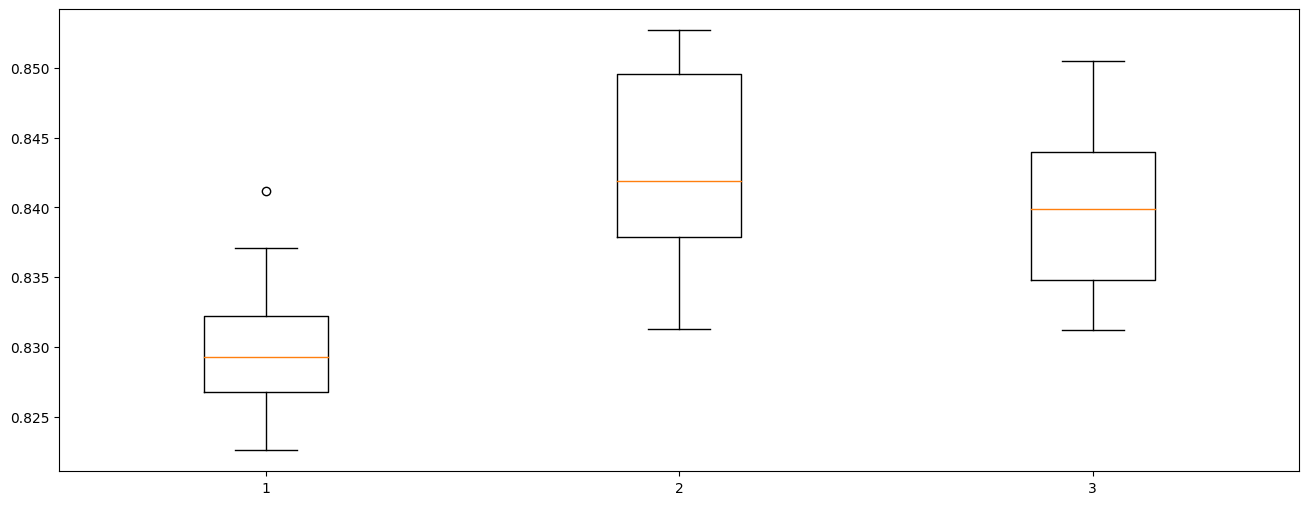

In [ ]:
plt.figure(figsize = (16., 6.))
plt.boxplot(samples)

In [ ]:
t_stat, p_val = stats.ttest_ind(samples[0], samples[1])
p_val


2.92006733473666e-06

***FC***

In [ ]:
class Net4(torch.nn.Module):
  def __init__(self):
    super(Net4, self).__init__()
    self.block1 = Block1(1,4)
    self.block2 = Block1(4,8)
    self.block3 = Block1(8,16)
    self.pool1 = torch.nn.Sequential(
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.ReLU6()
    )
    self.block4 = Block1(16,32)
    self.block5 = Block2(32, 64)
    self.block6 = Block2(64,128)
    self.pool2 = torch.nn.Sequential(
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.ReLU6()
    )
    self.fc1 = torch.nn.Linear(128*5*5,1024)
    self.act1 = torch.nn.ReLU6()
    self.fc2 = torch.nn.Linear(1024, 1024)
    self.act2 = torch.nn.ReLU6()
    self.fc3 = torch.nn.Linear(1024,35)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.pool1(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.pool2(x)
    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

In [ ]:
class Net5(torch.nn.Module):
  def __init__(self):
    super(Net5, self).__init__()
    self.block1 = Block1(1,4)
    self.block2 = Block1(4,8)
    self.block3 = Block1(8,16)
    self.pool1 = torch.nn.Sequential(
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.ReLU6()
    )
    self.block4 = Block1(16,32)
    self.block5 = Block2(32, 64)
    self.block6 = Block2(64,128)
    self.pool2 = torch.nn.Sequential(
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.ReLU6()
    )
    self.fc1 = torch.nn.Linear(128*5*5,4096)
    self.act1 = torch.nn.ReLU6()
    self.fc2 = torch.nn.Linear(4096, 4096)
    self.act2 = torch.nn.ReLU6()
    self.fc3 = torch.nn.Linear(4096,35)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.pool1(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.block6(x)
    x = self.pool2(x)
    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

In [ ]:
batch_size = 560
test_accuracies = []
for i in range(1):
  lenet4 = Net4().to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lenet4.parameters(), lr = 0.005, betas = (0.8, 0.9), eps = 1e-8, weight_decay = 0.001, amsgrad = False)
  test_accuracy = []
  for epoch in bar(range(100), desc = 'LEARNING', leave=False):
    indexs = np.random.permutation(len(train_data))

    for start_index in range(0, len(train_data), batch_size):
      optimizer.zero_grad()
      batch_index = indexs[start_index: start_index + batch_size]
      labels_batch = train_labels[batch_index].to(device)

      images_batch = train_data[batch_index].to(device)
      prediction = lenet4.forward(images_batch)
      loss_value = loss(prediction, labels_batch)
      loss_value.backward()
      optimizer.step()

    lenet4.eval()
    with torch.no_grad():
      prediction_test = lenet.forward(test_data)
      test_acc = (prediction_test.argmax(dim = 1) == test_labels).float().mean().data.cpu()
      test_accuracy.append(test_acc)
    lenet4.train()

  test_accuracies.append(test_accuracy)

In [ ]:
batch_size = 560
test_accuracies = []
for epoch in bar(100, desc = "NET5"):
  lenet5 = Net5().to(device)
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(lenet3.parameters(), lr = 0.005, betas = (0.8, 0.9), eps = 1e-8, weight_decay = 0.001, amsgrad = False)
  test_accuracy = []
  for epoch in bar(range(100), desc = 'LEARNING', leave=False):
    indexs = np.random.permutation(len(train_data))

    for start_index in range(0, len(train_data), batch_size):
      optimizer.zero_grad()
      batch_index = indexs[start_index: start_index + batch_size]
      labels_batch = train_labels[batch_index].to(device)

      images_batch = train_data[batch_index].to(device)
      prediction = lenet5.forward(images_batch)
      loss_value = loss(prediction, labels_batch)
      loss_value.backward()
      optimizer.step()

    lenet5.eval()
    with torch.no_grad():
      prediction_test = lenet.forward(test_data)
      test_acc = (prediction_test.argmax(dim = 1) == test_labels).float().mean().data.cpu()
      test_accuracy.append(test_acc)
    lenet5.train()

  test_accuracies.append(test_accuracy)

***EXPERIMENT***

In [ ]:
for i in range(1):
  accuracy_net = []
  for experiment in bar(range(10), desc = 'EXPERIMENT', leave = False):

    loss = torch.nn.CrossEntropyLoss()
    lenet4 = Net4().to(device)

    optimizer = torch.optim.Adam(lenet4.parameters(), lr = 0.005, betas = (0.8, 0.9), eps = 1e-8, weight_decay = 0.001, amsgrad = False)
    batch_size = 1120
    max_acc = 0

    for epoch in bar(range(100), leave=False):
      order = np.random.permutation(len(train_data))

      for start_index in range(0, len(train_data), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        data_batch = train_data[batch_indexes]
        labels_batch= train_labels[batch_indexes]

        preds = lenet4.forward(data_batch)

        loss_val = loss(preds, labels_batch)
        loss_val.backward()

        optimizer.step()
      lenet.eval()
      with torch.no_grad():
        test_preds = lenet3.forward(test_data)
        accuracy = (test_preds.argmax(dim=1)==test_labels).float().mean().data.cpu()
        max_acc = max(max_acc, accuracy)
      lenet4.train()
    accuracy_net.append(max_acc)
    print(max_acc)
  print(*accuracy_net)

In [ ]:
acc_4 = "tensor(0.8231) tensor(0.8315) tensor(0.8192) tensor(0.8173) tensor(0.8253) tensor(0.8108) tensor(0.8326) tensor(0.8360) tensor(0.8412) tensor(0.8315) tensor(0.8421) tensor(0.8388) tensor(0.8407) tensor(0.8342) tensor(0.8293) tensor(0.8355)"

In [ ]:
for i in range(1):
  accuracy_net = []
  for experiment in bar(range(10), desc = 'EXPERIMENT', leave = False):

    loss = torch.nn.CrossEntropyLoss()
    lenet5 = Net5().to(device)

    optimizer = torch.optim.Adam(lenet5.parameters(), lr = 0.005, betas = (0.8, 0.9), eps = 1e-8, weight_decay = 0.001, amsgrad = False)
    batch_size = 1120
    max_acc = 0

    for epoch in bar(range(100), leave=False):
      order = np.random.permutation(len(train_data))

      for start_index in range(0, len(train_data), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        data_batch = train_data[batch_indexes]
        labels_batch= train_labels[batch_indexes]

        preds = lenet5.forward(data_batch)

        loss_val = loss(preds, labels_batch)
        loss_val.backward()

        optimizer.step()
      lenet5.eval()
      with torch.no_grad():
        test_preds = lenet5.forward(test_data)
        accuracy = (test_preds.argmax(dim=1)==test_labels).float().mean().data.cpu()
        max_acc = max(max_acc, accuracy)
      lenet5.train()
    accuracy_net.append(max_acc)
    print(max_acc)
  print(*accuracy_net)

<ipython-input-16-76ce461f50da>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in bar(range(10), desc = 'EXPERIMENT', leave = False):


EXPERIMENT:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-16-76ce461f50da>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in bar(range(100), leave=False):


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8304)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8266)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8368)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8309)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8300)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8344)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8333)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8297)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8337)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8226)
tensor(0.8304) tensor(0.8266) tensor(0.8368) tensor(0.8309) tensor(0.8300) tensor(0.8344) tensor(0.8333) tensor(0.8297) tensor(0.8337) tensor(0.8226)


In [ ]:
acc_5 = "tensor(0.8373) tensor(0.8347) tensor(0.8552) tensor(0.8411) tensor(0.8386) tensor(0.8402) tensor(0.8451) tensor(0.8436) tensor(0.8383) tensor(0.8312) tensor(0.8411) tensor(0.8446) tensor(0.8490) tensor(0.8501) tensor(0.8451) tensor(0.8357) tensor(0.8422)"

In [ ]:
samples = [acc_4, acc_5]
for i in range(len(samples)):
    samples[i] = list(map(float, samples[i].replace("tensor(", '').replace(')', '').replace("[","").replace("]", "").split()))

{'whiskers': [<matplotlib.lines.Line2D at 0x79f931f57700>,
 'caps': [<matplotlib.lines.Line2D at 0x79f841447400>,
 'boxes': [<matplotlib.lines.Line2D at 0x79f852b2c3a0>,
 'medians': [<matplotlib.lines.Line2D at 0x79f841447130>,
 'fliers': [<matplotlib.lines.Line2D at 0x79f841446b90>,
 'means': []}

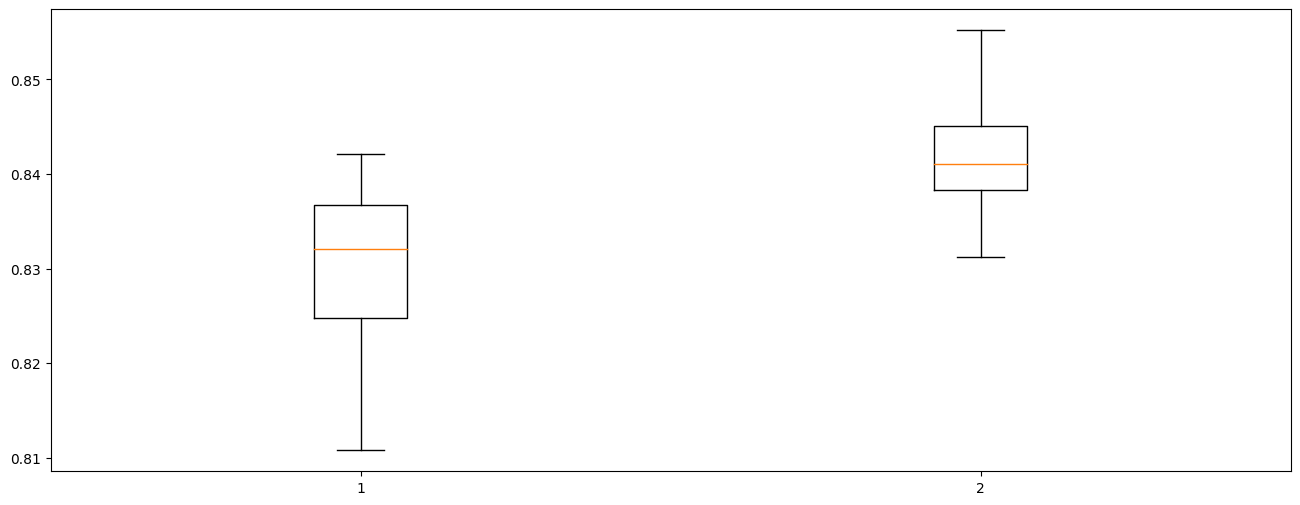

In [ ]:
plt.figure(figsize = (16., 6.))
plt.boxplot(samples)

In [ ]:
t_stat, p_val = stats.ttest_ind(samples[0], samples[1])
p_val

0.0001925771097828218

net5 - лучшая сеть